# Experiment - Data Preparation Techniques
* StelllarAlgo Data Science
* Ryan Kazmerik, Grant Donst, Peter Morrison
* Dec 02, 2022

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from shared_utilities import helpers
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from pycaret.classification import *

## Let's load in a training dataset from Redshift:

In [2]:
CLUSTER = "prod-app"
DATABASE = "stlrbluejays"
LKUPCLIENTID = "50"
SCORING_YEAR = 2022
PRODUCT_MAPPING = {'Flex Plan': 0, 'Mini Plan': 1, 'Quarter Season': 2, 'Half Season': 3, 'Full Season': 4}
PRODUCT_CURRENT_MAPPING = {'Individual': 0, 'Group': 1, 'Mini Pack': 2, 'Quarter': 3, 'Half Season': 4, 'Full Season': 5}

In [3]:
dataset = helpers.get_product_propensity_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    scoring_year=SCORING_YEAR,
    type_flag=0
)

dataset.shape

Authorized as AROASQ4JELIXYLYV6P4UV:pmorrison@stellaralgo.com


(491767, 27)

### Let's choose a smaller set of features for this experiment:

In [4]:
features = [
    "atp_last",
    "attended_last",
    "distance",
    "events_last",
    "spend_current",
    "sends",
    "tenure",
    "opens",
    "product",
    "volume_current"
]

In [67]:
df = dataset.copy()

In [68]:
df = df[features]
df.shape

(491767, 10)

### Let's filter our data to product plans only:

In [69]:
product_plans = [
   "Full Season",
   "Game Pack",
   "Leadoff Offer",
   # "Hotel",
   "Rooms"
]

In [70]:
df = df[df["product"].isin(product_plans)].reset_index(drop=True)
df.shape

(6380, 10)

In [71]:
df_before = df

## Let's visualize the dimensionality of our dataset:

In [72]:
df_before["product_encoded"] = df_before["product"].astype("category").cat.codes
df_before = df_before.drop(["product"], axis=1)

In [73]:
df_before = df_before.dropna()

### We can use PCA to represent all of our features in three aggregated features:

In [74]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_before)

df_before['pca-one'] = pca_result[:,0]
df_before['pca-two'] = pca_result[:,1] 
df_before['pca-three'] = pca_result[:,2]

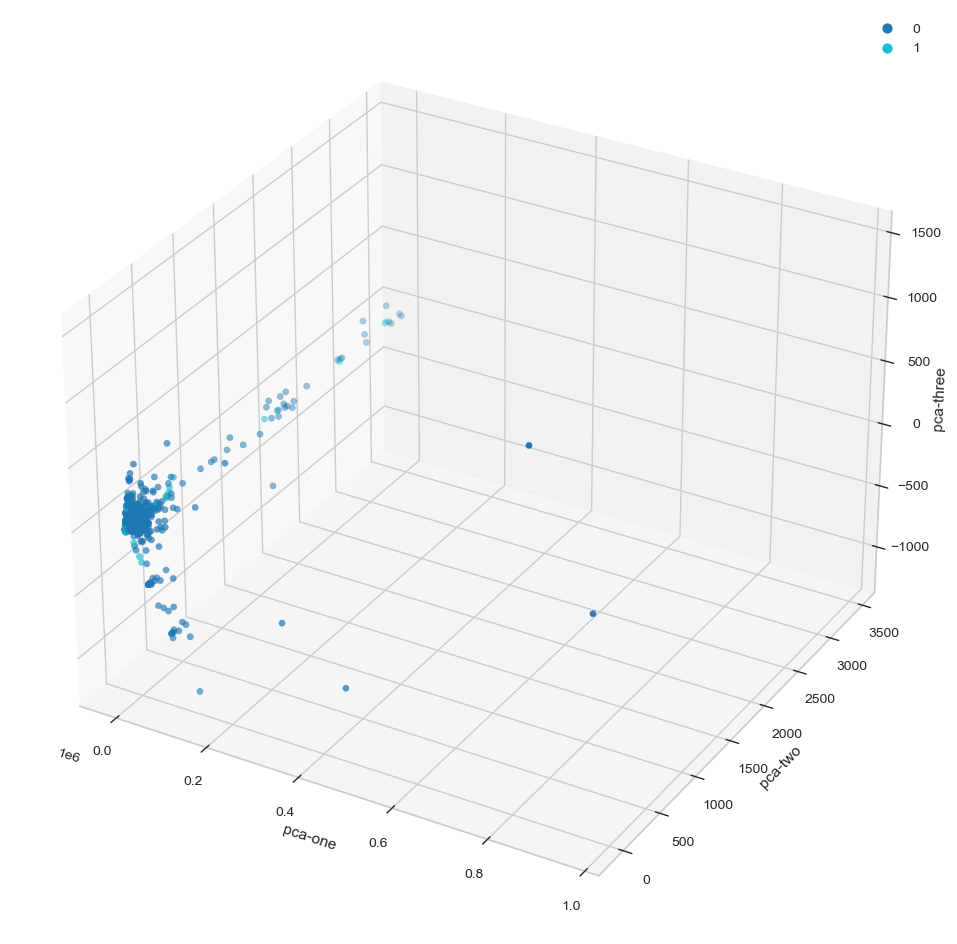

In [75]:
ax = plt.figure(figsize=(12,12)).gca(projection='3d')
chart = ax.scatter(
   xs=df_before["pca-one"], 
   ys=df_before["pca-two"], 
   zs=df_before["pca-three"], 
   c=df_before["product_encoded"], 
   cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

ax.legend(*chart.legend_elements())
plt.show()

## Let's try imputing some missing values:

In [76]:
df["atp_last"] = df["atp_last"].fillna(method="backfill")

In [77]:
df["attended_last"] = df["attended_last"].fillna(method="backfill")
df["events_last"] = df["events_last"].fillna(method="backfill")

In [78]:
df["opens"] = df["opens"].fillna(method="backfill")
df["sends"] = df["sends"].fillna(method="backfill")

## Let's remove some outliers from our data:

In [79]:
def subset_by_iqr(df, column, whisker_bottom=1.5, whisker_top=1.5):
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_bottom*iqr) & (df[column] <= q3 + whisker_top*iqr)
    return df.loc[filter]       

In [80]:
df = subset_by_iqr(df, 'atp_last', 1.0)
df = subset_by_iqr(df, 'spend_current', 1.5, 1.0)
df = subset_by_iqr(df, 'distance', 1.5, 1.5)
df = subset_by_iqr(df, 'opens', 1.5, 1.0)
df = subset_by_iqr(df, 'volume_current', 1.5, 1.0)
df.shape

(4317, 11)

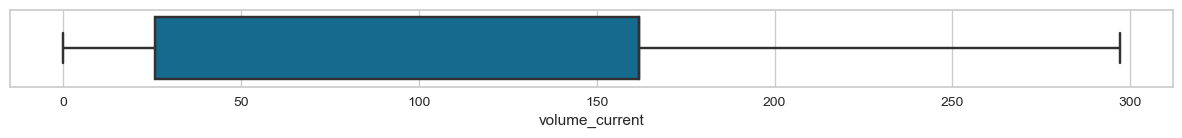

In [81]:
plt.figure(figsize=(15,1))
sns.boxplot(x=df["volume_current"])
plt.show()

## Let's resample our data using SMOTE to fix class imbalance on our target variable:

In [82]:
df = df.dropna()

In [83]:
df["product"].value_counts()

Full Season      2610
Game Pack        1682
Leadoff Offer      25
Name: product, dtype: int64

In [84]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df.drop(["product"], axis=1), df["product"])

In [85]:
df = X_res
df["product"] = y_res

In [86]:
df.head()

,atp_last,attended_last,distance,events_last,spend_current,sends,tenure,opens,volume_current,product_encoded,product
0,76.55,1.0,4.22,1.0,838.40,3.0,3,0.0,12,0,Full Season
1,59.65,11.0,40.29,80.0,5215.88,16.0,1,1.0,162,0,Full Season
2,59.65,11.0,26.46,80.0,9664.00,2.0,1,1.0,162,0,Full Season
3,59.65,11.0,26.46,80.0,9182.00,2.0,3,1.0,162,0,Full Season
4,64.83,7.0,6.70,13.0,1685.50,12.0,1,36.0,26,1,Game Pack


In [87]:
df.shape

(7830, 11)

## Let's check the datatypes infered by Pandas to see if they are correct:

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7830 entries, 0 to 7829
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   atp_last         7830 non-null   float64
 1   attended_last    7830 non-null   float64
 2   distance         7830 non-null   float64
 3   events_last      7830 non-null   float64
 4   spend_current    7830 non-null   float64
 5   sends            7830 non-null   float64
 6   tenure           7830 non-null   int64  
 7   opens            7830 non-null   float64
 8   volume_current   7830 non-null   int64  
 9   product_encoded  7830 non-null   int8   
 10  product          7830 non-null   object 
dtypes: float64(7), int64(2), int8(1), object(1)
memory usage: 619.5+ KB


## Let's visualize the dimensionality of our dataset:

In [89]:
df["product_encoded"] = df["product"].astype("category").cat.codes
df = df.drop(["product"], axis=1)

In [90]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

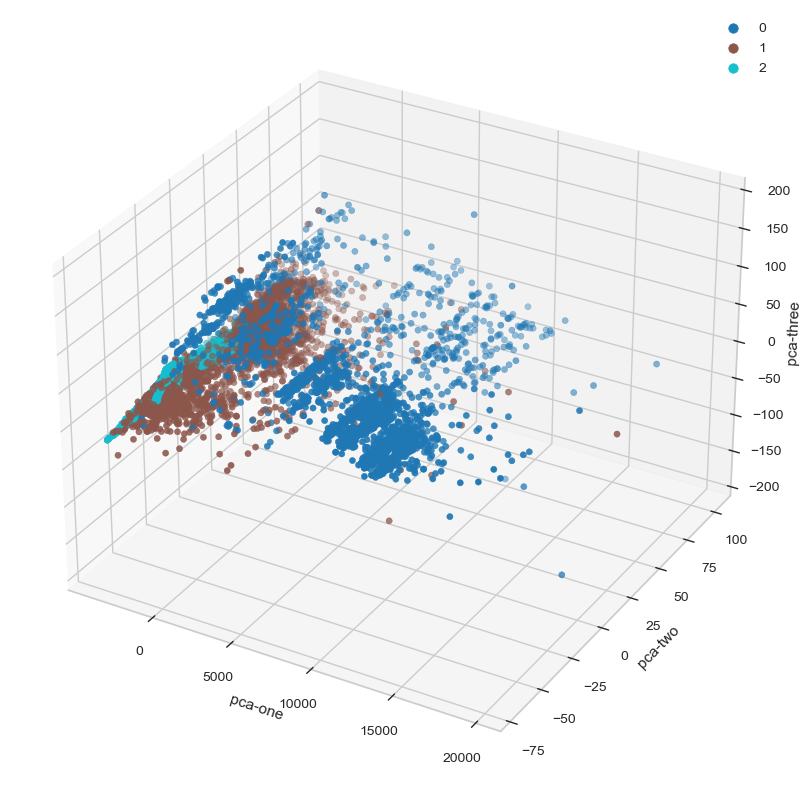

In [91]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
chart = ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["product_encoded"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

ax.legend(*chart.legend_elements())
plt.show()

### We have reduced the dimensionality of our dataset quite a bit and the vector space required to capture each data point is much smaller.

# Done